
# Naive Bayes
In Naive Bayes, we learn:
- a *prior* for the probability of each class by counting relative frequency of class labels in the dataset.
    - for multi-class classification, wich $C$ classes, this is a categorical distribution $\mathrm{Categorical}(y=c_0; \pi) = \prod_c \pi_c^{\mathbb{I}(y=c)} = \pi_{c_0}$. MLE is given by $\pi_c = \frac{N(y=c)}{N}$.
- a probability for the value of each feature $x_d$, conditioned on the class label $y$. The type of this probability distribution depends on the feature type. Here, we only consider the **Gaussian** distribution: $p(x_d| y=c, \mathcal{D}) = \mathcal{N}(x_d; \mu_{d,c}, \sigma_{d,c})$. The maximum likelihood is given by the empirical mean and variance of feature $x_d$ for instances belonging to class $c$.

Once we learn both the class prior $p(y)$ and class conditionals $p(x_d|y)$ from the data, we can use the Bayes rule to calculate posterior class probability
$p(y| x) \propto p(y) p(x| y)$. 

In [1]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets

## Fitting the data
Below, first we implement the `fit` function that learns the model parameters. We use Laplace smoothing for the class prior using $\alpha=\beta=1$.

In [2]:

class GaussianNaiveBayes:
    
    def __init__(self):
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        # one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C) # number of instances in class c
        # for each class get the MLE for the mean and std
        for c in range(C):
            x_c = x[y == c]                           #slice all the elements from class c
            Nc[c] = x_c.shape[0]                      #get number of elements of class c
            mu[c,:] = np.mean(x_c,0)                  #mean of features of class c
            sigma[c,:] = np.std(x_c, 0)               #std of features of class c
            
        self.mu = mu                                  # C x D
        self.sigma = sigma                            # C x D
        self.pi = (Nc+1)/(N+C)                        #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        return self

## Prediction for new data
So far we have produced model parameters. To calculate the posterior for new instances, we need to evaluate
$$
\tilde{p}(y=c| x) = \mathrm{Categorical}(c; \pi) \prod_{d} \mathcal{N}(x_d; \mu_{d, c}, \sigma^2_{d,c})
$$
with large number of features $D$, the product will encounter a numerical problem since it can grow too large or too small.
For this reason we work in the log domain:
$$
\log \tilde{p}(y=c| x) = \log(\pi_c) +  \sum_{d} \log \left (\mathcal{N}(x_d; \mu_{d, c}, \sigma^2_{d,c}) \right)
$$
Logarithm of the Gaussian takes the following form:
$$
\log \left (\mathcal{N}(x_d; \mu_{d, c}, \sigma^2_{d,c}) \right) = -\frac{1}{2} \log(2\pi) - \log(\sigma_{d,c}) -  \frac{(x - \mu_{d,c})^2}{2\sigma_{d,c}^2}.
$$

### Normalization and numerical stability
At this point we have logarithm of **unnormalized** posterior $\log \tilde{p}(y=c| x, \mathcal{D}) \forall c$. 
To get the probabilities, we need to normalize. We can do this in the log domain as well:
$$
\log p(y=c|x) =  (\log \tilde{p}(y=c| x)) - \log \left (\sum_{c'} \exp (\log \tilde{p}(y=c| x)) \right )
$$

In [3]:
def logsumexp(Z):                                                # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt):
    Nt, D = xt.shape
    # for numerical stability we work in the log domain
    # we add a dimension because this is added to the log-likelihood matrix 
    # that assigns a likelihood for each class (C) to each test point, and so it is C x N
    log_prior = np.log(self.pi)[:, None]
    # logarithm of the likelihood term for Gaussian 
    # the first two terms are the logarithm of the normalization term in the Gaussian and the final term is the exponent in the Gaussian. 
    # Notice that we are adding dimensions (using None) to model parameters and data to make this evaluation. 
    # The reason is that sigma and mu are C x D, while the data x is N x D. We operate on a C x N x D shape by increasing the number of dimensions when needed
    log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:]) -.5 * (((xt[None,:,:] - self.mu[:,None,:])/self.sigma[:,None,:])**2)
    # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
    log_likelihood = np.sum(log_likelihood, axis=2)
    # posterior calculation
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return posterior.T                                                  # dimension N x C

GaussianNaiveBayes.predict = predict

## Experiment

In [4]:
from sklearn import model_selection
x, y = datasets.load_iris(return_X_y=True)
x = x[:, :2]
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2) # this is similar to our manual split above
model = GaussianNaiveBayes()
model.fit(x_train, y_train)
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, 1)
accuracy = np.sum(y_pred == y_test)/y_pred.shape[0]
print(f'test accuracy: {accuracy}')

test accuracy: 0.7333333333333333


## Decision boundary
This is the same procedure we used for drawing) the decision boundary and probabilities produced for the K-NN and the Decision tree.
We also mark the mean of the Gaussian for each class using a `x`.

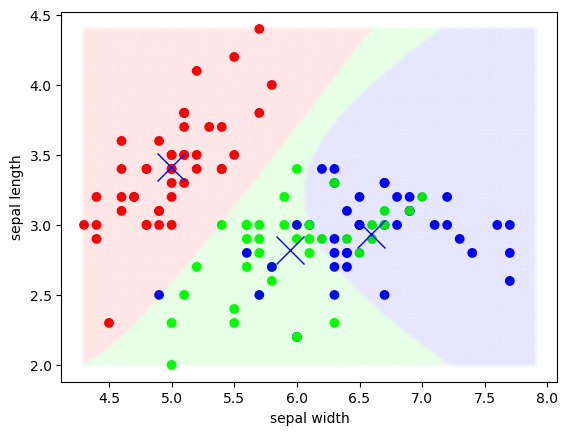

In [5]:
num_classes = np.max(y) + 1
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
y_train_prob = np.zeros((y_train.shape[0], num_classes))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
y_prob_all = model.fit(x_train, y_train).predict(x_all)
y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, 1)] = 1
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=.01)
plt.plot(model.mu[:,0], model.mu[:,1], 'bx', markersize=20)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

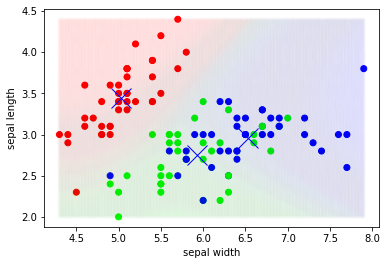

In [ ]:
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
plt.plot(model.mu[:,0], model.mu[:,1], 'bx', markersize=20)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()
